# Code for analysis of GM to WM contrast in SC images and SC QSM processing steps

In [ ]:
import nibabel as nib
import numpy as np  
import sys
import os

In [13]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy import stats

In [6]:
# Lets begin analyzing our best looking magnitude
hc2_m1_mag_img = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\hc2_m1_mag.nii.gz")
hc2_m1_mag_data = hc2_m1_mag_img.get_fdata()
# Now lets load the custom masks
hc2_m1_gm_msk_data = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1/custom_hc2_m1_gm_msk.nii.gz").get_fdata()
hc2_m1_wm_msk_data = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_wm_msk.nii.gz").get_fdata()

In [7]:
hc2_m1_def_pdf_def_tkd_data = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\chi_map\def_pdf_to_def_tkd\Sepia_Chimap.nii.gz").get_fdata()
hc2_m1_opt_pdf_def_tkd_data = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\chi_map\opt_pdf_to_def_tkd\Sepia_Chimap.nii.gz").get_fdata()

In [4]:
nSlices = hc2_m1_mag_img.shape[2]
nSlices

16

In [5]:
contrast_values = np.full(nSlices, np.nan)

for s in range(nSlices):
    wm_slice = hc2_m1_wm_msk_data[:, :, s].astype(bool)
    gm_slice = hc2_m1_gm_msk_data[:, :, s].astype(bool)

    wm_vals = hc2_m1_mag_data[:, :, s][wm_slice]
    gm_vals = hc2_m1_mag_data[:, :, s][gm_slice]

    if wm_vals.size > 0 and gm_vals.size > 0:
        mu_wm = wm_vals.mean()
        mu_gm = gm_vals.mean()

        contrast_values[s] = (mu_gm - mu_wm) / (mu_gm + mu_wm)  # signed contrast

# contrast_values now contains the GM–WM contrast for each slice
print(contrast_values)


[0.07211565 0.05832177 0.1012321  0.03194563 0.05406769 0.08772266
 0.06536509 0.0661796  0.07663165 0.07719194 0.06496995 0.08389183
 0.06915417 0.04618036 0.07092932 0.07579492]


# <span style="color:orange"> Difference of mean in Chimaps // *For SC QSM* </br>
In this section we'll perform a statistical test looking to see if the difference between of the GM and WM mean is significant or not.


In [9]:
# Load the chimap you want to analyuze
chimap_img = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\chi_map\MRI_suscep_calc\opt_kspace_solver\thr_0_03103\Sepia_Chimap.nii.gz")
chimap_data = chimap_img.get_fdata()

# Now load the masks or custom masks you want to use to calculate the mean 
wm_mask_data = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_gm_msk.nii.gz").get_fdata()
gm_mask_data = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_wm_msk.nii.gz").get_fdata()
                      

In [ ]:
# Extract voxel values
wm_vals = chimap_data[wm_mask_data == 1]
gm_vals = chimap_data[gm_mask_data == 1]

# Remove NaN/inf values
wm_vals = wm_vals[np.isfinite(wm_vals)]
gm_vals = gm_vals[np.isfinite(gm_vals)]

# Means
wm_mean = np.mean(wm_vals)
gm_mean = np.mean(gm_vals)
mean_diff = gm_mean - wm_mean  # Substract WM because it should always be negative

In [10]:
# Extract voxel values
wm_vals1 = hc2_m1_def_pdf_def_tkd_data[wm_mask_data == 1]
gm_vals1 = hc2_m1_def_pdf_def_tkd_data[gm_mask_data == 1]

wm_vals2 = hc2_m1_opt_pdf_def_tkd_data[wm_mask_data == 1]
gm_vals2 = hc2_m1_opt_pdf_def_tkd_data[gm_mask_data == 1]

# Means
wm_mean1 = np.mean(wm_vals1)
gm_mean1 = np.mean(gm_vals1)

wm_mean2 = np.mean(wm_vals2)
gm_mean2 = np.mean(gm_vals2)

mean_diff_gm = gm_mean1 - gm_mean2  # Substract WM because it should always be negative
mean_diff_wm = wm_mean1 - wm_mean2  # Substract WM because it should always be negative

In [7]:
print(f"WM Mean: {wm_mean:.4f}, GM Mean: {gm_mean:.4f}, Mean Difference (GM - WM): {mean_diff:.4f}")

WM Mean: -0.0024, GM Mean: 0.0113, Mean Difference (GM - WM): 0.0137


In [8]:
print("WM voxel count:", wm_vals.size)
print("GM voxel count:", gm_vals.size)

WM voxel count: 2252
GM voxel count: 477


Not a big difference in voxel counts indicates that there may not be big imbalance (and if there is, this may not be why)

In [9]:
print("WM variance:", np.var(wm_vals))
print("GM variance:", np.var(gm_vals))

WM variance: 0.00014209096997019693
GM variance: 0.00014395087720924058


Nonzero viarance is good, also variance is similar which indicates that independendent t-test is a good fit :)

In [10]:
# Check no Nans, because this messes up the stats
print("NaNs in WM:", np.isnan(wm_vals).sum())
print("NaNs in GM:", np.isnan(gm_vals).sum())
print("Infs in WM:", np.isinf(wm_vals).sum())
print("Infs in GM:", np.isinf(gm_vals).sum())


NaNs in WM: 0
NaNs in GM: 0
Infs in WM: 0
Infs in GM: 0


In [11]:
# Just in case remove NaN/inf values again
wm_vals_clean = wm_vals[np.isfinite(wm_vals)]
gm_vals_clean = gm_vals[np.isfinite(gm_vals)]

In [11]:
t_stat, p_val = ttest_ind(gm_vals1, gm_vals2, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4e}")

T-statistic: 0.8698, p-value: 3.8444e-01


In [12]:
t_stat, p_val = ttest_ind(wm_vals1, wm_vals2, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4e}")

T-statistic: -1.8482, p-value: 6.4881e-02


In [20]:
from scipy.stats import mannwhitneyu

stat, p_val = mannwhitneyu(gm_vals1, gm_vals2, alternative='two-sided')
print(f"Mann-Whitney U statistic of GM: {stat:.4f}, p-value: {p_val:.4e}")


Mann-Whitney U statistic of GM: 2552395.0000, p-value: 7.0290e-01


In [21]:
from scipy.stats import mannwhitneyu

stat, p_val = mannwhitneyu(wm_vals1, wm_vals2, alternative='two-sided')
print(f"Mann-Whitney U statistic of WM: {stat:.4f}, p-value: {p_val:.4e}")


Mann-Whitney U statistic of WM: 103517.5000, p-value: 1.6043e-02


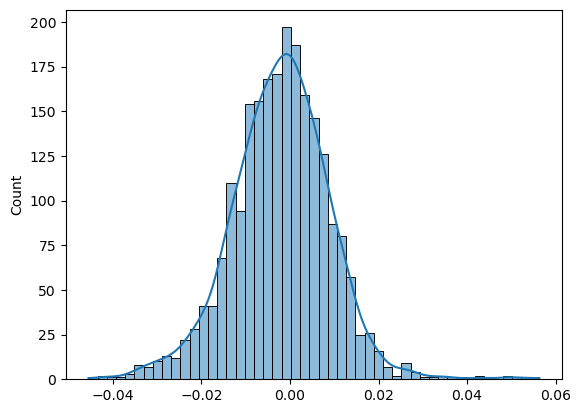

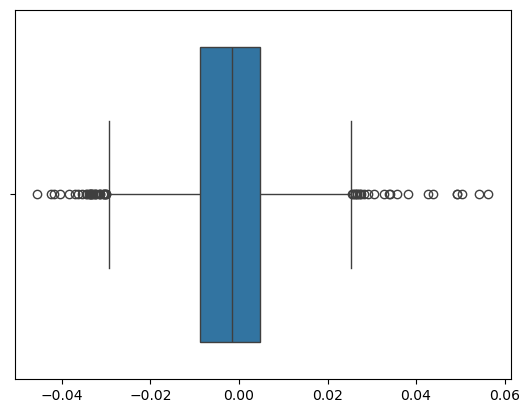

In [ ]:
# Wilccoxon signed rank 

In [19]:
# Shapiro Wil test for normality
from scipy.stats import normaltest

stat , p = normaltest(gm_vals1)
print(f"Normal test: {stat:.4f}, p-value: {p:.4e}")



Normal test: 96.2218, p-value: 1.2755e-21


### Just in case you want to do the statistical test manually

In [17]:
# Rememmber that s^2 is the sample variance we calculated with np.var()
x1_mean = -0.0023
x2_mean = 0.0113
s1_sq = 0.0001358
s2_sq = 0.0001337
n1 = 2252
n2 = 477

In [18]:
diff = x1_mean - x2_mean
se = np.sqrt(s1_sq / n1 + s2_sq / n2)
t_stat = diff / se

# Degrees of freedom
numer = (s1_sq / n1 + s2_sq / n2)**2
denom = ( (s1_sq / n1)**2 / (n1 - 1) ) + ( (s2_sq / n2)**2 / (n2 - 1) )
df = numer / denom

print(f"t-statistic: {t_stat:.4f}")
print(f"Degrees of freedom: {df:.2f}")

t-statistic: -23.3034
Degrees of freedom: 696.03


In [20]:
from scipy.stats import t

# t_stat and df from previous calculation
t_stat_abs = abs(t_stat)  # use absolute value for two-tailed test

# Two-tailed p-value
p_val = 2 * (1 - t.cdf(t_stat_abs, df))

print(f"Two-tailed p-value: {p_val}")

Two-tailed p-value: 0.0
